In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
df=pd.read_csv('/content/sample_data/Emotion_final.csv')
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [3]:
df['Emotion'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

In [5]:
df=df.dropna()

In [6]:
X=df.drop('Emotion',axis=1)
y=df['Emotion']

In [7]:
### Vocabulary size
voc_size=10000

In [8]:
messages=X.copy()
messages.reset_index(inplace=True)

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['Text'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [11]:
corpus[:10]

['didnt feel humili',
 'go feel hopeless damn hope around someon care awak',
 'im grab minut post feel greedi wrong',
 'ever feel nostalg fireplac know still properti',
 'feel grouchi',
 'ive feel littl burden late wasnt sure',
 'ive take milligram time recommend amount ive fallen asleep lot faster also feel like funni',
 'feel confus life teenag jade year old man',
 'petrona year feel petrona perform well made huge profit',
 'feel romant']

In [12]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [13]:
#Finding max words
l = 0
for x in corpus:
    l = max(l,len(x.split(' ')))
print(l)

35


In [14]:
sent_length=35
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 9643 9210 5585]
 [   0    0    0 ... 3432 2073 5090]
 [   0    0    0 ... 9210 9835 4321]
 ...
 [   0    0    0 ... 4778 4013 9082]
 [   0    0    0 ... 6010 9082   83]
 [   0    0    0 ...    0 9082 7089]]


In [15]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 9643,
       9210, 5585], dtype=int32)

In [16]:
# Creating model
embedding_vector_features=100
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model.add(Dropout(0.3))
model.add(Dense(6,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 100)           1000000   
_________________________________________________________________
dropout (Dropout)            (None, 35, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3

In [17]:
label_encoder = preprocessing.LabelEncoder()
X_final=np.array(embedded_docs)
y = label_encoder.fit_transform(y)
y_final=np.array(y)
print(y_final)

[4 4 0 ... 1 1 1]


In [18]:
X_final.shape,y_final.shape

((21459, 35), (21459,))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=21)

In [20]:
model_save = ModelCheckpoint('weights.h5', save_best_only = True, save_weights_only = True, monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10,batch_size=256,callbacks = [model_save])

Epoch 1/10
61/61 [==============================] - 18s 241ms/step - loss: 2.7058 - accuracy: 0.3329 - val_loss: 1.5713 - val_accuracy: 0.3885

Epoch 00001: val_loss improved from inf to 1.57125, saving model to weights.h5
Epoch 2/10
61/61 [==============================] - 14s 227ms/step - loss: 1.2616 - accuracy: 0.6168 - val_loss: 1.0617 - val_accuracy: 0.6686

Epoch 00002: val_loss improved from 1.57125 to 1.06165, saving model to weights.h5
Epoch 3/10
61/61 [==============================] - 14s 228ms/step - loss: 0.9391 - accuracy: 0.7256 - val_loss: 0.9023 - val_accuracy: 0.7303

Epoch 00003: val_loss improved from 1.06165 to 0.90227, saving model to weights.h5
Epoch 4/10
61/61 [==============================] - 14s 227ms/step - loss: 0.8048 - accuracy: 0.7643 - val_loss: 0.8711 - val_accuracy: 0.7268

Epoch 00004: val_loss improved from 0.90227 to 0.87115, saving model to weights.h5
Epoch 5/10
61/61 [==============================] - 14s 227ms/step - loss: 0.7643 - accuracy: 0.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


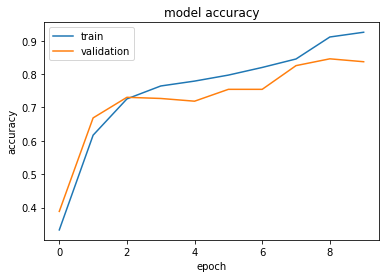

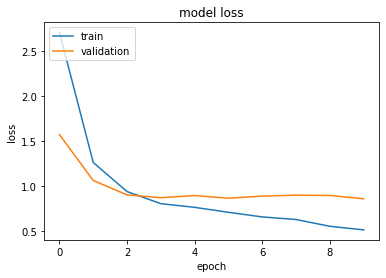

In [21]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
model.load_weights('weights.h5')

In [23]:
y_pred=model.predict_classes(X_test)
print(y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[2 0 4 ... 0 0 2]


In [24]:
print(accuracy_score(y_test,y_pred))

0.8583410997204101


In [25]:
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.81997   0.87844   0.84820       617
           1    0.84431   0.79661   0.81977       531
           2    0.87597   0.89500   0.88539      1381
           3    0.68314   0.73899   0.70997       318
           4    0.92689   0.89350   0.90989      1277
           5    0.74306   0.63690   0.68590       168

    accuracy                        0.85834      4292
   macro avg    0.81556   0.80658   0.80985      4292
weighted avg    0.85966   0.85834   0.85841      4292



Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)


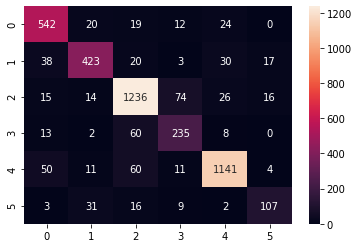

In [26]:
print('Confusion Matrix')
print(sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt="d"))

In [27]:
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'anger': 0, 'fear': 1, 'happy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}


In [28]:
#Example
def predict_emotion(stri):
    review = re.sub('[^a-zA-Z]', ' ', stri)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    onehot_repr = [one_hot(review,voc_size)] 
    embed = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
    predicti = model.predict(embed)
    return label_encoder.classes_[np.argmax(predicti)]

In [29]:
predict_emotion('I am very happy and joyful today')

'happy'

In [30]:
predict_emotion('Big Data Analytics is cool')

'happy'